# Import Libraries

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression

from dmba import plotDecisionTree, classificationSummary, gainsChart, liftChart

import statsmodels.api as sm
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from pycaret.classification import *
from mord import LogisticIT

import matplotlib.pylab as plt
%matplotlib inline

ModuleNotFoundError: No module named 'lightgbm'

# Data Set

## Load Data Set

In [3]:
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
data = pd.read_csv("train.csv", index_col=['id'])
test = pd.read_csv("test.csv", index_col=['id'])
data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
id,,,,,,,,,,,,,,,,,,
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,3,0,0,4,0,0,1,160,2018,12,30,1,0,0,0,140.00,2,1
42096,2,0,0,3,0,0,0,34,2017,9,23,0,0,0,0,224.67,0,0
42097,2,0,0,2,2,0,0,292,2018,7,21,0,0,0,0,96.00,0,0


## EDA with data set

In [5]:
data.shape

(42100, 18)

In [ ]:
data.describe()

In [ ]:
data.info()

In [8]:
missing_data = data.isna().mean(axis=0)
missing_data

no_of_adults                            0.0
no_of_children                          0.0
no_of_weekend_nights                    0.0
no_of_week_nights                       0.0
type_of_meal_plan                       0.0
required_car_parking_space              0.0
room_type_reserved                      0.0
lead_time                               0.0
arrival_year                            0.0
arrival_month                           0.0
arrival_date                            0.0
market_segment_type                     0.0
repeated_guest                          0.0
no_of_previous_cancellations            0.0
no_of_previous_bookings_not_canceled    0.0
avg_price_per_room                      0.0
no_of_special_requests                  0.0
booking_status                          0.0
dtype: float64

In [9]:
train_dups =  data.duplicated().sum()
test_dups = test.duplicated().sum()


print(f'''
train:    {train_dups}
test:     {test_dups}
''')

-------------------------
train:           0
test:            253



In [ ]:
data['booking_status'].value_counts()

In [ ]:
sns.boxplot(data.lead_time)

In [ ]:
fig, ax1 = plt.subplots()

ax1 = sns.barplot(x = "arrival_month", y = "booking_status", 
                  data = data.sort_values('booking_status'), palette = "Set1")

In [ ]:
corr = data.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr, cmap="RdBu_r", annot=True, vmax=1, vmin=-1)
plt.show()

# Classification Models

## Test Train Split

In [4]:
X = data.drop(columns=['booking_status'])
y = data['booking_status']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

## Catboost

### Train Model

In [44]:
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
model.fit(train_X,
          train_y,
          verbose=False)

### Accuracy

In [45]:
classificationSummary(valid_y, model.predict(valid_X))

Confusion Matrix (Accuracy 0.8194)

       Prediction
Actual    0    1
     0 8958 1313
     1 1728 4841


### Predictions

In [46]:
test_pred = model.predict(test)

In [47]:
test['booking_status'] = test_pred


In [48]:
test_prediction_df = pd.DataFrame(test, columns=['booking_status'])
test_prediction_df

,booking_status
id,
42100,0
42101,0
42102,0
42103,0
42104,1
...,...
70163,1
70164,0
70165,0


In [49]:
test_prediction_df.to_csv('cat_test_prediction.csv')

## Lightgbm

### Train Model

In [57]:
lgb_train = lgb.Dataset(train_X, train_y)
lgb_eval = lgb.Dataset(valid_X, valid_y, reference=lgb_train)

In [60]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary'#,
#     'num_boost_round':20,
#     'valid_sets':lgb_eval,
#     'callback':lgb.early_stopping(stopping_rounds=10)
}

In [62]:
# train
gbm = lgb.train(params, lgb_train)

[LightGBM] [Info] Number of positive: 9935, number of negative: 15325
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 25260, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393310 -> initscore=-0.433422
[LightGBM] [Info] Start training from score -0.433422


In [63]:
y_pred = gbm.predict(valid_X, num_iteration=gbm.best_iteration)

### Accuracy

In [64]:
classificationSummary(valid_y, y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

## Decision Trees

### Train Model

In [ ]:
# Grow full classification tree using training partition.
fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(train_X, train_y)

### Accuracy

In [ ]:
print('Training Partition')
classificationSummary(train_y, fullClassTree.predict(train_X))

print()
print('Validation Partition')
classificationSummary(valid_y, fullClassTree.predict(valid_X))

### Find and Train Best Model

In [ ]:
treeClassifier = DecisionTreeClassifier()

scores = cross_val_score(treeClassifier, train_X, train_y, cv=5)

print('Performance Accuracy of 5-Fold Cross-Validation')
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in scores])

print()
print('Two Standard Deviation (95%) Confidence Interval for Mean Accuracy')
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})')

In [ ]:
param_grid = {
    'max_depth': [5, 7, 10, 20],  
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
    'min_samples_split': [.5, 1, 5, 10, 15, 20, 40],
}

gridSearch_init = GridSearchCV(DecisionTreeClassifier(), 
                   param_grid, cv=5, n_jobs=-1)
gridSearch_init.fit(train_X, train_y)

print(f'Initial score:{gridSearch_init.best_score_:.4f}')
print('Initial parameters: ', gridSearch_init.best_params_)

In [ ]:
param_grid = {
    'max_depth': list(range(2, 20)),  
    'min_impurity_decrease': [0.0001,0.0002, 0.0003, 0.0004, 0.0005,0.0007, 0.0007, 0.001], 
    'min_samples_split': [.5,.6,.7,.8,.9,1,2,3,4],
}

gridSearch = GridSearchCV(DecisionTreeClassifier(), 
                param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)

print()
print(f'Improved score:{gridSearch.best_score_:.4f}')
print('Improved parameters: ', gridSearch.best_params_)

In [ ]:
bestClassTree = gridSearch.best_estimator_

### Accuracy

In [ ]:
print('Training Partition')
classificationSummary(train_y, bestClassTree.predict(train_X))

print()
print('Validation Partition')
classificationSummary(valid_y, bestClassTree.predict(valid_X))

In [ ]:
pred_best_tree = bestClassTree.predict(test)

In [ ]:
pred_best_tree

## XGBoost

In [28]:
xgb_cl = xgb.XGBClassifier()

### Train Model

In [30]:
xgb_cl.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [34]:
preds = xgb_cl.predict(valid_X)

### Accuracy

In [35]:
accuracy_score(valid_y, preds)

0.8229216152019002

### Predictions

In [ ]:
test_preds = xgb_cl.predict(test)
test_preds

In [ ]:
test_prediction_df = pd.DataFrame(test, columns=['booking_status'])
test_prediction_df

In [ ]:
# test_prediction_df.to_csv('test_prediction.csv')

## XGBoost Part 2 - Tweaking Parameters

In [39]:
params = {
            "objective": "binary:logitraw",
            "eval_metric": "auc",
            'booster': 'gbtree',
            'n_estimators': 5000,
            'max_depth' : 5, 
            'eta':  0.02465211760946184, 
            'random_state': 33333,
            "scale_pos_weight": 1, 
            'subsample': 0.8807634510839019,
            'sampling_method': 'uniform', 
            'colsample_bytree':0.7615746338125093, 
            'colsample_bylevel': 0.9190448386294816,
            'colsample_bynode': 0.9190448386294816,

}

In [40]:
xgb_cl = xgb.XGBClassifier(**params)

In [41]:
xgb_cl.fit(train_X, train_y)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.9190448386294816,
              colsample_bynode=0.9190448386294816,
              colsample_bytree=0.7615746338125093, early_stopping_rounds=None,
              enable_categorical=False, eta=0.02465211760946184,
              eval_metric='auc', feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=5000, n_jobs=None, num_parallel_tree=None,
              objective='binary:logitraw', ...)

In [42]:
preds = xgb_cl.predict(valid_X)

### Accuracy

In [43]:
accuracy_score(valid_y, preds)

0.8185866983372921

## Logistic Regression

### Train Model

In [65]:
log_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
log_reg.fit(train_X, train_y)

# Show intercept and coefficients of the multiple predictors' logistic model.
print('Parameters of Logistic Regresion Model with Multiple Predictors')
print('Intercept:', np.round(log_reg.intercept_[0], decimals=3))
print('Coefficients for Predictors')
print(pd.DataFrame({'Coeff:': np.round(log_reg.coef_[0], decimals=3)}, 
                    index=X.columns).transpose())

Parameters of Logistic Regresion Model with Multiple Predictors
Intercept: -0.001
Coefficients for Predictors
        no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
Coeff:         0.091           0.146                 0.084              0.032   

        type_of_meal_plan  required_car_parking_space  room_type_reserved  \
Coeff:             -0.003                       -0.57              -0.258   

        lead_time  arrival_year  arrival_month  arrival_date  \
Coeff:      0.013        -0.002         -0.034         0.002   

        market_segment_type  repeated_guest  no_of_previous_cancellations  \
Coeff:                1.099          -0.367                        -0.131   

        no_of_previous_bookings_not_canceled  avg_price_per_room  \
Coeff:                                -0.639                0.02   

        no_of_special_requests  
Coeff:                  -1.199  


In [66]:
log_pred = log_reg.predict(valid_X)

log_prob = np.round(log_reg.predict_proba(valid_X), decimals=4)

log_result = pd.DataFrame({'Actual': valid_y, 
                    'Classification': log_pred,
                    'p(0)': [p[0] for p in log_prob],
                    'p(1)': [p[1] for p in log_prob]
})

print('Classification for Validation Partition')
print(log_result.head(20))

Classification for Validation Partition
       Actual  Classification    p(0)    p(1)
id                                           
37633       0               0  0.6571  0.3429
24516       0               0  0.9087  0.0913
31459       1               1  0.2577  0.7423
24091       0               0  0.7857  0.2143
13874       0               1  0.4104  0.5896
11389       0               1  0.4791  0.5209
24845       0               0  0.8014  0.1986
40782       1               1  0.3400  0.6600
31545       1               0  0.6048  0.3952
34242       0               0  0.9573  0.0427
39795       0               0  0.5656  0.4344
40756       0               0  0.9694  0.0306
37004       0               0  0.6786  0.3214
25524       0               0  0.9712  0.0288
30219       0               0  0.6331  0.3669
26793       0               0  0.9497  0.0503
17910       0               1  0.2667  0.7333
33915       1               1  0.1713  0.8287
37723       0               0  1.0000  0

### Accuracy

In [67]:
print('Training Partition')
classificationSummary(train_y, log_reg.predict(train_X))

print()
print('Validation Partition')
classificationSummary(valid_y, log_reg.predict(valid_X))

Training Partition
Confusion Matrix (Accuracy 0.7649)

       Prediction
Actual     0     1
     0 12752  2573
     1  3366  6569

Validation Partition
Confusion Matrix (Accuracy 0.7651)

       Prediction
Actual    0    1
     0 8576 1695
     1 2261 4308


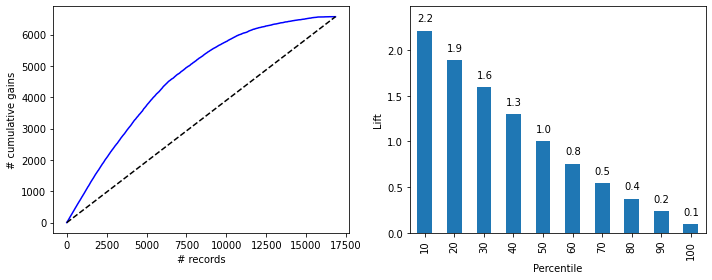

In [68]:
df = log_result.sort_values(by=['p(1)'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.Actual, ax=axes[0], color='Blue')

liftChart(df['p(1)'], title=False, ax=axes[1])
 
plt.tight_layout()
plt.show()

### Predictions

## Statsmodel version

### Train Model

In [69]:
data_sm = data 

data_sm = sm.add_constant(data_sm, prepend=True)

log_reg_sm = sm.GLM(train_y, train_X, family=sm.families.Binomial())
log_result_sm = log_reg_sm.fit()
print(log_result_sm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         booking_status   No. Observations:                25260
Model:                            GLM   Df Residuals:                    25243
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12430.
Date:                Mon, 27 Feb 2023   Deviance:                       24860.
Time:                        14:59:33   Pearson chi2:                 2.69e+04
No. Iterations:                    14   Pseudo R-squ. (CS):             0.2997
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


### Accuracy

In [70]:
logit_ord = LogisticIT(alpha=0)
logit_ord.fit(train_X, train_y)

print('Ordinal Logistic Regression')
print('  Intercepts', np.round(logit_ord.theta_, decimals=3))
print('  Coefficients', np.round(logit_ord.coef_, decimals=3))
print()

results_ord = logit_ord.predict(valid_X)
prob_ord = np.round(logit_ord.predict_proba(valid_X), decimals=4)

print()
print('Classification for First 10 Records in Validation Data Set')
results_ord = pd.DataFrame({
    'Actual': valid_y, 'Classification': results_ord,
    'P(0)': [p[0] for p in prob_ord],
    'P(1)': [p[1] for p in prob_ord]})

print(results_ord.head(10))

Ordinal Logistic Regression
  Intercepts [0.001]
  Coefficients [ 0.052  0.173  0.081  0.023 -0.006 -1.145 -0.336  0.012 -0.002 -0.032
  0.002  1.143 -0.759 -0.294 -1.4    0.02  -1.229]


Classification for First 10 Records in Validation Data Set
       Actual  Classification    P(0)    P(1)
id                                           
37633       0               0  0.6489  0.3511
24516       0               0  0.9061  0.0939
31459       1               1  0.2502  0.7498
24091       0               0  0.7923  0.2077
13874       0               1  0.4014  0.5986
11389       0               1  0.4635  0.5365
24845       0               0  0.8251  0.1749
40782       1               1  0.3224  0.6776
31545       1               0  0.6043  0.3957
34242       0               0  0.9619  0.0381


In [71]:
print('Training Partition for Ordinal Logistic Model')
classificationSummary(train_y, logit_ord.predict(train_X))

print()
print('Validation Partition for Ordinal Logistic Model')
classificationSummary(valid_y, logit_ord.predict(valid_X))

Training Partition for Ordinal Logistic Model
Confusion Matrix (Accuracy 0.7664)

       Prediction
Actual     0     1
     0 12744  2581
     1  3319  6616

Validation Partition for Ordinal Logistic Model
Confusion Matrix (Accuracy 0.7666)

       Prediction
Actual    0    1
     0 8569 1702
     1 2228 4341


## Pycaret

### Train Model

In [72]:
s = setup(data, target = 'booking_status', train_size = 0.6, fold_shuffle=True, 
          preprocess=False, use_gpu=True)

,Description,Value
0,session_id,812
1,Target,booking_status
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(42100, 18)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,13
8,Transformed Train Set,"(25260, 17)"
9,Transformed Test Set,"(16840, 17)"


In [73]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8202,0.8939,0.7430,0.7867,0.7642,0.6191,0.6198,6.8760
gbc,Gradient Boosting Classifier,0.8113,0.8787,0.7115,0.7869,0.7472,0.5973,0.5993,1.9030
rf,Random Forest Classifier,0.8042,0.8744,0.7220,0.7653,0.7430,0.5851,0.5858,1.4140
et,Extra Trees Classifier,0.7924,0.8461,0.7143,0.7455,0.7295,0.5612,0.5615,3.8750
ada,Ada Boost Classifier,0.7916,0.8672,0.7201,0.7412,0.7304,0.5607,0.5610,5.4510
lda,Linear Discriminant Analysis,0.7675,0.8315,0.6686,0.7189,0.6928,0.5062,0.5071,0.1240
ridge,Ridge Classifier,0.7673,0.0000,0.6648,0.7202,0.6913,0.5050,0.5061,0.0780
lr,Logistic Regression,0.7647,0.8298,0.6547,0.7201,0.6858,0.4984,0.4999,0.9140
dt,Decision Tree Classifier,0.7401,0.7299,0.6629,0.6707,0.6667,0.4537,0.4538,0.1690
knn,K Neighbors Classifier,0.7265,0.7743,0.6146,0.6632,0.6379,0.4187,0.4195,0.2340


In [74]:
cat = create_model('catboost', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8179,0.8971,0.7242,0.7931,0.7571,0.6119,0.6136
1,0.8147,0.8919,0.7323,0.7812,0.7560,0.6069,0.6077
2,0.8250,0.8959,0.7596,0.7866,0.7729,0.6306,0.6309
3,0.8262,0.8960,0.7606,0.7885,0.7743,0.6331,0.6333
4,0.8258,0.9011,0.7465,0.7963,0.7706,0.6304,0.6313
5,0.8131,0.8850,0.7283,0.7803,0.7534,0.6033,0.6042
6,0.8195,0.8935,0.7437,0.7849,0.7637,0.6178,0.6184
7,0.8294,0.8997,0.7568,0.7979,0.7768,0.6389,0.6394
8,0.8191,0.8904,0.7427,0.7846,0.7631,0.6169,0.6175
9,0.8116,0.8887,0.7356,0.7731,0.7539,0.6014,0.6019


### Accuracy

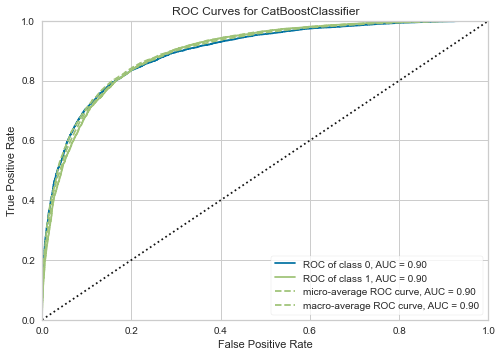

In [78]:
plot_model(best)

In [79]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Predictions

In [75]:
test_pred = predict_model(cat, data = test)

In [76]:
test_pred

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,Label,Score
id,,,,,,,,,,,,,,,,,,,,
42100,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2,0,0,0.8840
42101,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0,0,0,0.9295
42102,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1,0,0,0.6488
42103,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0,0,0,0.9074
42104,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0,1,1,0.5485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70163,2,0,1,2,0,0,0,315,2018,9,30,1,0,0,0,160.00,0,1,1,0.9319
70164,2,0,2,2,0,0,0,81,2018,3,25,0,0,0,0,65.00,1,0,0,0.9698
70165,2,0,1,2,0,0,0,40,2018,10,22,0,0,0,0,85.00,0,0,0,0.8939


In [77]:
# test_pred.to_csv('pycaret_pred.csv')